In [143]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import salem
import numpy as np
from cdo import Cdo
cdo = Cdo()
import re
import sys
sys.path.append("/home/abhi/Documents/mygit/postBC_diagnostic/src/scripts")
from recipes import *
from pathlib import Path
import os
import dask.array as da
from scipy import stats
import _pickle as cpickle

In [138]:
modelIndex = pd.Index(['IMD', 'PRECIS', 'HADGEM2-ES'], name='model')
seasIndex = pd.Index(['Annual', 'JJAS', 'ON', 'DJF', 'MAM'], name='seas')
varIndex = pd.Index(['precip', 'tmax', 'tmean', 'tmin'], name='var_name')

In [55]:
def getFile(model, var, metric, seas=None):
    if metric in ['wetdayprecip_1mm', 'wetdayfreq_1mm'] or re.match(r'pd_[0-9]+mm', metric):
        metric_name, thresh = metric.split('_')
        return f"../data/{model}/{var}/{metric_name}/1971-2000_rm_ll25_{seas}_{metric_name}_{thresh}.nc"
    elif metric == 'monmean':
        return f"../data/{model}/{var}/{metric}/1971-2000_rm_ll25_{metric}.nc"
    else:
        return f"../data/{model}/{var}/{metric}/1971-2000_rm_ll25_{seas}_{metric}.nc"


In [59]:
def getvarname(model, var):
    if model in ['IMD', 'PRECIS']:
        return {'precip': 'precip',
               'tmean': 'tmean',
               'tmax': 'tmax',
               'tmin': 'tmin'}[var]
    
    elif model == 'HADGEM2-ES':
        return {'precip': 'pr',
               'tmean': 'tas',
               'tmax': 'tasmax',
               'tmin': 'tasmin'}[var]

def gettimename(model, var):
    if ((model in ['IMD', 'HADGEM2-ES'])
        or
        (model == 'PRECIS') and (var == 'tmean')):
        
        return 'time'
    
    elif model == 'PRECIS':
        return 't'

In [164]:
getCompareFile = lambda m1, m2, var, metric, seas: \
f'/home/abhi/Documents/mygit/GCM_RCM/data/{m1}_{m2}/{var}/{metric}/1971-2000_rm_ll25_{seas}_{metric}.nc'

### Trend plots

In [12]:
def regression(y, axis='time'):
    axis_num = y.get_axis_num(axis)
    return np.apply_along_axis(_calc_slope, axis_num, y)

def _calc_slope(y):
    x = np.arange(len(y))
    return [stats.linregress(x, y).slope, stats.linregress(x, y).pvalue]


In [30]:
def _calc_slope(y):
    x = np.arange(len(y))
    try:
        return [stats.theilslopes(y, x)[0], 
                stats.kendalltau(x, y)[1]]
    except Exception:
        return [stats.linregress(x, y).slope, stats.kendalltau(x, y)[1]]

def regression(y, axis='time'):
    axis_num = y.get_axis_num(axis)
    return np.apply_along_axis(_calc_slope, axis_num, y)


In [171]:
objs = []
var = 'precip'
seas = 'Annual'

def getModelCombinedObjs(var, seas, metric='monmean', apply_ymean=False):
    
    objs = []
    for model in modelIndex:
        var_name = getvarname(model, var)
        time_name = gettimename(model, var)
        
        if metric in ['BIAS', 'RMSE', 'timcor'] and model is not 'IMD':
            f = getCompareFile(model, 'IMD', var, metric, seas)
            continue
        else:
            f = getFile(model, var,metric)
        
        ds = (xr.open_dataset(f)[var_name].rename({time_name:'time'}))

        if seas != 'Annual':
            ds = selseas(ds, seas)


        try:
            ds = ds.drop('height')
        except Exception:
            pass
        
        if apply_ymean:
            ds = yearmean(ds)
            
        objs.append(ds)
        
    return objs

In [172]:
getCompareFile('PRECIS', 'IMD', 'precip', 'BIAS', 'Annual')

'/home/abhi/Documents/mygit/GCM_RCM/data/PRECIS_IMD/precip/BIAS/1971-2000_rm_ll25_Annual_BIAS.nc'

In [139]:
combined = xr.concat([xr.concat(
    [xr.concat(getModelCombinedObjs(var, seas, True), dim=models)
     for var in varIndex], dim=varIndex) 
                      for seas in seasIndex], dim=seasIndex)


/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [216]:
with open("../pickles/Analysis-3/combined_ymean.pkl", "wb") as f:
    cpickle.dump(combined.to_dataset(), f)

In [142]:
%%time
res = regression(combined, axis='year')

/home/abhi/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


CPU times: user 16min 45s, sys: 8 ms, total: 16min 45s
Wall time: 16min 45s


In [145]:
res.shape

(5, 4, 3, 2, 129, 135)

In [150]:
stats = ['slope', 'p_value']
variables = varIndex
coords = {'seas': seasIndex, 
          'var_name': varIndex,
          'model': models, 
          'stats': stats, 
          'lat': ds.lat, 
          'lon': ds.lon}

In [151]:
ds_out = xr.Dataset({'trend_stats':
                     (coords.keys(),
                      res)}, coords = coords)

In [153]:
os.system("mkdir -p ../pickles/Analysis-3")
with open("../pickles/Analysis-3/trend_ds.pkl", "wb") as f:
    cpickle.dump(ds_out, f)

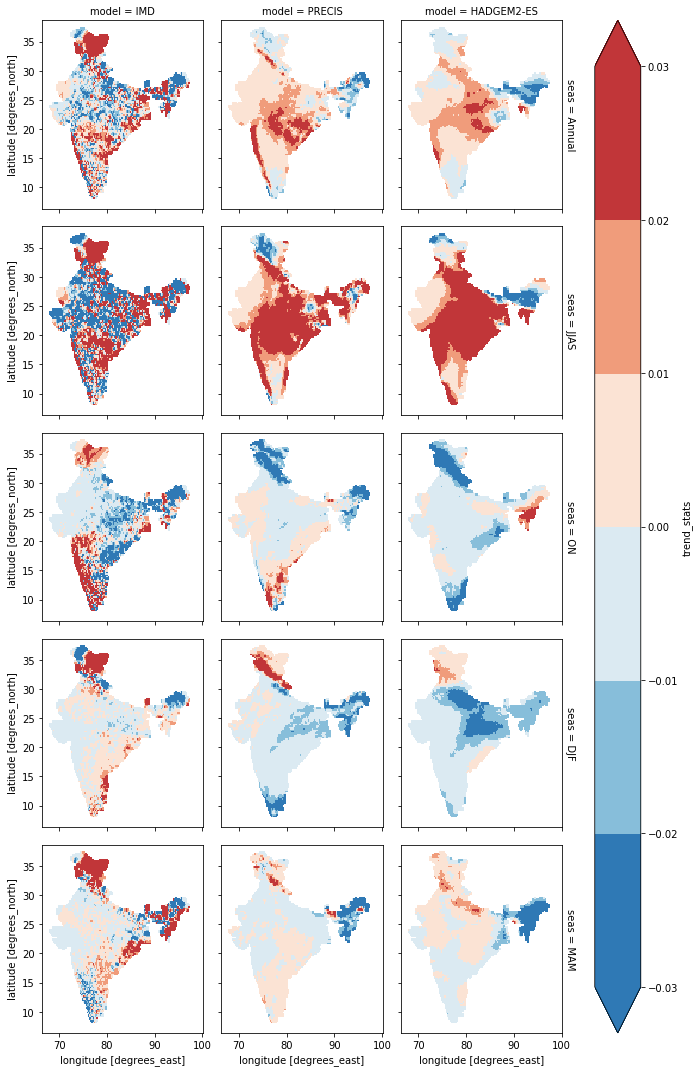

In [222]:
ds_out.sel(stats='slope', var_name='precip').trend_stats.plot(col='model', row='seas', 
                                           levels=np.arange(-0.03, 0.031, 0.01), extend='both')

In [176]:
combined_ds = combined.to_dataset().rename({'precip': 'VAR'})

In [177]:
combined_ds

<xarray.Dataset>
Dimensions:   (lat: 129, lon: 135, model: 3, seas: 5, var_name: 4, year: 30)
Coordinates:
  * lon       (lon) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
  * lat       (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * year      (year) int64 1971 1972 1973 1974 1975 ... 1996 1997 1998 1999 2000
  * model     (model) object 'IMD' 'PRECIS' 'HADGEM2-ES'
  * var_name  (var_name) object 'precip' 'tmax' 'tmean' 'tmin'
  * seas      (seas) object 'Annual' 'JJAS' 'ON' 'DJF' 'MAM'
Data variables:
    VAR       (seas, var_name, model, year, lat, lon) float32 nan nan ... nan

In [191]:
DIFF = combined_ds.sel(model=['PRECIS', 'HADGEM2-ES']).VAR - combined_ds.sel(model='IMD')

In [192]:
BIAS = DIFF.mean(dim='year')

In [200]:
PERC_BIAS = (BIAS/(combined_ds.sel(model='IMD')).mean(dim='year'))*100

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [195]:
RMSE = ((DIFF**2).mean(dim='year'))**(1/2)

In [208]:
PERC_RMSE = (RMSE/((combined_ds.sel(model='IMD')).mean(dim='year')))*100

In [209]:
metricIndex = pd.Index(['BIAS', 'PERC_BIAS', 'RMSE', 'PERC_RMSE'], name='metric')
combined_metric = xr.concat([BIAS, PERC_BIAS, RMSE, PERC_RMSE], dim=metricIndex)

In [211]:
with open("../pickles/Analysis-3/combined_metric", "wb") as f:
    cpickle.dump(combined_metric, f)

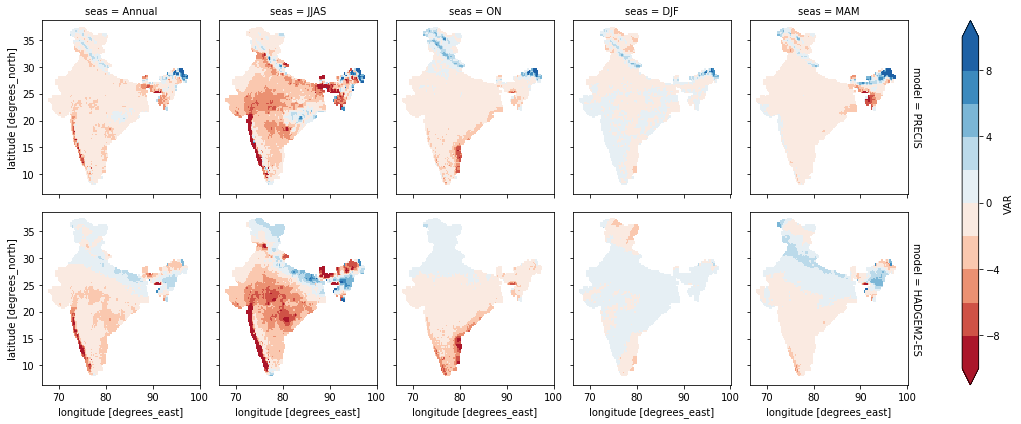

In [219]:
plot = BIAS.sel(var_name='precip').VAR.plot(row='model', col='seas',
                                                     levels=np.arange(-10, 12, 2),
                                           cmap='RdBu')


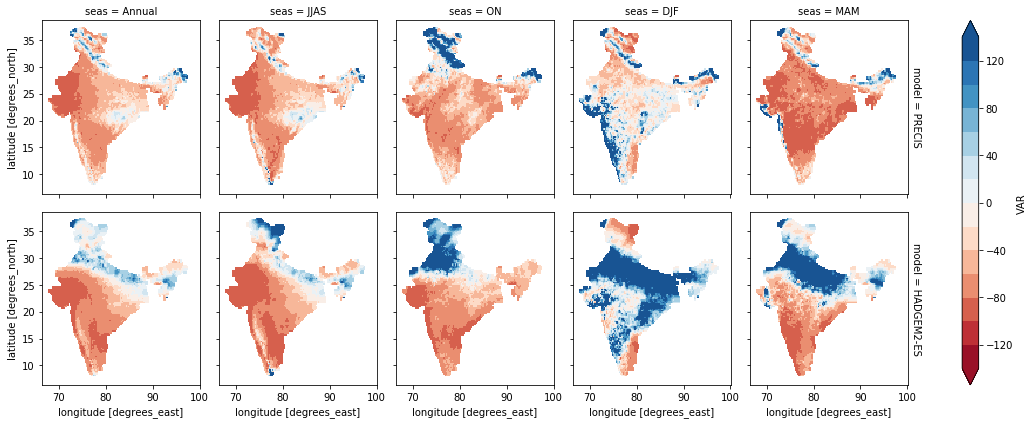

In [212]:
plot = PERC_BIAS.sel(var_name='precip').VAR.plot(row='model', col='seas', levels=np.arange(-140, 160, 20),
                                                cmap='RdBu', extend='both')


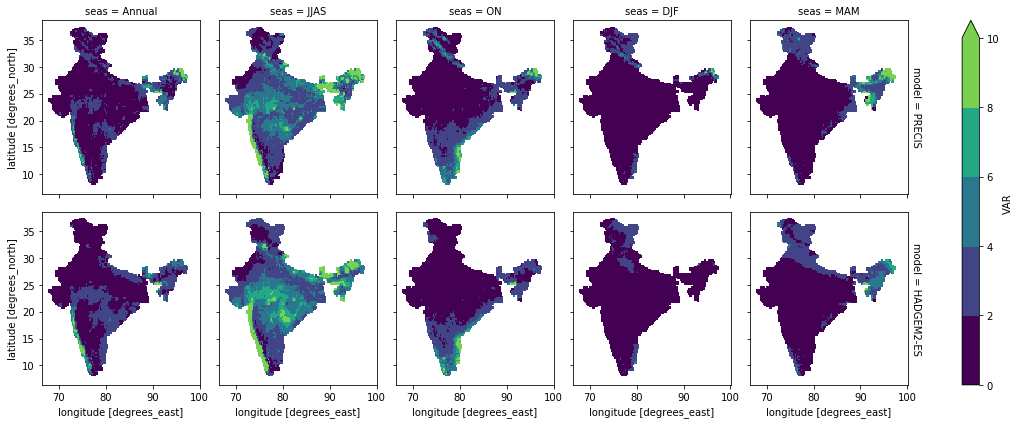

In [196]:
plot = RMSE.sel(var_name='precip').VAR.plot(row='model', col='seas',
                                                     levels=np.arange(0, 12, 2))
